### importing required libraries

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [315]:
# importing train and test data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [316]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [317]:
# checking wether dataset is balanced or not
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### feature engineering and feature selection

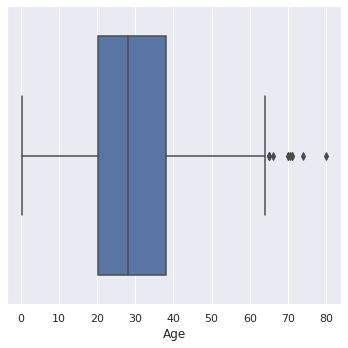

(29.69911764705882, 28.0)

In [318]:
sns.catplot(x='Age',data = train,kind= 'box')
plt.show()
train.Age.mean(),train.Age.median()

here,data of missing value of age according to target class suggests that more than 70% people whose age is missing is not survived, so I assumed all those of older people

In [319]:
train[train['Age'].isnull()].Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [320]:
# filling the null value in Age
age = int(train['Age'].mean()+3*train.Age.std())

In [321]:
train.Age.fillna(age,inplace=True)
test.Age.fillna(int(test['Age'].mean()+3*test.Age.std()),inplace = True)

In [322]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [323]:
# filling null value with most frequent class
train.Embarked.fillna('S',inplace=True)

In [324]:
del train['Ticket']

In [325]:
del test['Ticket']

In [326]:
train['Name_label'] = train.Name.str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()

In [327]:
test['Name_label'] = test.Name.str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()

In [328]:
del train['Name']

In [329]:
del test['Name']

In [330]:
top4_freq_name_label = list(train.Name_label.value_counts().index[:4])
top4_freq_name_label

['Mr', 'Miss', 'Mrs', 'Master']

In [331]:
train['Name_label'][(train['Name_label'] != 'Mr') &
                   (train['Name_label'] != 'Miss') & 
                   (train['Name_label'] != 'Mrs') &
                   (train['Name_label'] != 'Master')] = 'Other'


In [332]:
test['Name_label'][(test['Name_label'] != 'Mr') &
                   (test['Name_label'] != 'Miss') & 
                   (test['Name_label'] != 'Mrs') &
                   (test['Name_label'] != 'Master')] = 'Other'


In [333]:
del train['PassengerId']

In [334]:
del test['PassengerId']

In [335]:
sibsp_map = {0:0,1:1, 2:2, 3:2,4:2,5:2, 8:2}
train.SibSp = train.SibSp.map(sibsp_map)
test.SibSp = test.SibSp.map(sibsp_map)

In [336]:
parch_map = {0:0,1:1, 2:2, 3:2,4:2,5:2, 6:2}
train.Parch = train.Parch.map(sibsp_map)
test.Parch = test.Parch.map(parch_map)
test.Parch.fillna(2,inplace = True)

In [337]:
train['Cabin'][train['Cabin'].isnull()] = 'Missing'
train['Cabin'] = train['Cabin'].str[0]

In [338]:
test['Cabin'][test['Cabin'].isnull()] = 'Missing'
test['Cabin'] = test['Cabin'].str[0]

In [339]:
print(train.Cabin.value_counts())
print(test.Cabin.value_counts())

M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64
M    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64


In [340]:
cabin_map = {'M':'M','C':'C','B':'B','D':'D','E':'E','A':'A','F':'F','G':'G','T':'G'}
train.Cabin = train.Cabin.map(cabin_map)
test.Cabin = test.Cabin.map(cabin_map)

In [341]:
train.Cabin = train.Cabin.astype('O')
test.Cabin = test.Cabin.astype('O')

In [342]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_label
0,0,3,male,22.0,1,0.0,7.2500,M,S,Mr
1,1,1,female,38.0,1,0.0,71.2833,C,C,Mrs
2,1,3,female,26.0,0,0.0,7.9250,M,S,Miss
3,1,1,female,35.0,1,0.0,53.1000,C,S,Mrs
4,0,3,male,35.0,0,0.0,8.0500,M,S,Mr


In [343]:
test.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Cabin         0
Embarked      0
Name_label    0
dtype: int64

In [344]:
test.Fare.fillna(test['Fare'].median(),inplace = True)

In [345]:
print('Pclass',len(train.Pclass.value_counts()))
print('Sex',len(train.Sex.value_counts()))
print('SibSp',len(train.SibSp.value_counts()))
print('Parch',len(train.Parch.value_counts()))
print('Cabin',len(train.Cabin.value_counts()))
print('Embarked',len(train.Embarked.value_counts()))
print('Name_label',len(train.Name_label.value_counts()))

print('Pclass',len(test.Pclass.value_counts()))
print('Sex',len(test.Sex.value_counts()))
print('SibSp',len(test.SibSp.value_counts()))
print('Parch',len(test.Parch.value_counts()))
print('Cabin',len(test.Cabin.value_counts()))
print('Embarked',len(test.Embarked.value_counts()))
print('Name_label',len(test.Name_label.value_counts()))

Pclass 3
Sex 2
SibSp 3
Parch 3
Cabin 8
Embarked 3
Name_label 5
Pclass 3
Sex 2
SibSp 3
Parch 3
Cabin 8
Embarked 3
Name_label 5


In [346]:
train.Parch = train.Parch.astype(object)
train.SibSp = train.SibSp.astype(object)
test.Parch = test.Parch.astype(object)
test.SibSp = test.SibSp.astype(object)

In [347]:
pd.get_dummies(train,drop_first= True).head()

,Survived,Pclass,Age,Fare,Sex_male,SibSp_1,SibSp_2,Parch_1.0,Parch_2.0,Cabin_B,...,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Embarked_Q,Embarked_S,Name_label_Miss,Name_label_Mr,Name_label_Mrs,Name_label_Other
0,0,3,22.0,7.2500,1,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
1,1,1,38.0,71.2833,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,3,26.0,7.9250,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,1,1,35.0,53.1000,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,3,35.0,8.0500,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [348]:
print(train.groupby('Pclass')['Survived'].value_counts())

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64


In [349]:
pclass_map = {1:3,2:2,3:1}
train.Pclass = train.Pclass.map(pclass_map)
test.Pclass = test.Pclass.map(pclass_map)

In [350]:
train.groupby('Pclass')['Survived'].value_counts()

Pclass  Survived
1       0           372
        1           119
2       0            97
        1            87
3       1           136
        0            80
Name: Survived, dtype: int64

In [351]:
train_final = pd.get_dummies(train,drop_first = True)
test_final = pd.get_dummies(test,drop_first = True)

In [352]:
train_final.shape,test_final.shape

((891, 22), (418, 21))

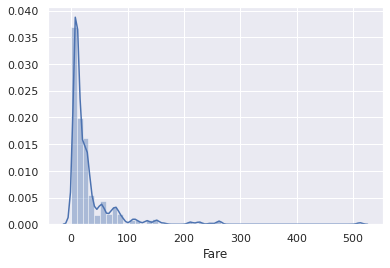

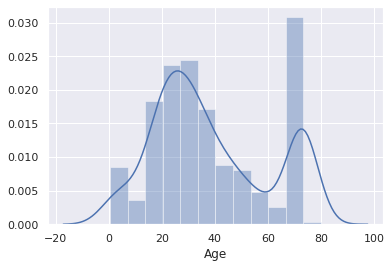

In [354]:
sns.distplot(train_final.Fare)
plt.show()
sns.distplot(train_final.Age)
plt.show()

adding a new column which suggest if the passenger was adult or not

In [355]:
train_final['adult'] = np.where(train_final['Age']>18,1,0)
test_final['adult'] = np.where(test_final['Age']>18,1,0)

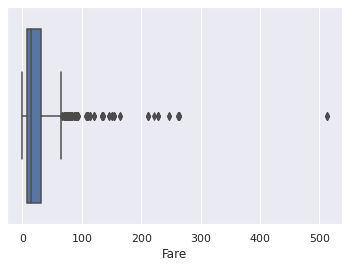

In [356]:
sns.boxplot(train.Fare)

to remove the outlier in Fare column, I have replaced all those with 100

In [357]:
train_final.Fare[train_final['Fare']>100] = 100

In [358]:
test_final.Fare[test_final['Fare']>100] = 100

In [359]:
ip_train = train_final.drop('Survived',axis = 1)
op_train = train_final['Survived']

In [361]:
x_train,x_test,y_train,y_test = train_test_split(ip_train,op_train,random_state = 0,test_size = 0.2)

In [362]:
LR_alg = LogisticRegression(
                            multi_class = 'multinomial',
                            solver = 'sag',
                            max_iter = 5000
                            )
LR_alg.fit(x_train,y_train)
logistic_regression_accuracy = LR_alg.score(x_test,y_test)
print(logistic_regression_accuracy)

0.8156424581005587


In [363]:
RF_alg = RandomForestClassifier(
                                n_estimators = 100,
                                random_state = 0
                                )
RF_alg.fit(x_train,y_train)
random_forest_accuracy = RF_alg.score(x_test,y_test)
print(random_forest_accuracy)

0.8379888268156425


### hypertuning of RandomForestClassifier

In [436]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2,20,5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2,10,5)]
# Method of selecting samples for training each tree
bootstrap = [True]
criterion = ['gini','entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 6, 11, 15, 20],
 'min_samples_leaf': [2, 4, 6, 8, 10],
 'bootstrap': [True],
 'criterion': ['gini', 'entropy']}

In [366]:
rf = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=0, n_jobs = -1)
rf_random_search.fit(x_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 6, 11, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
             

In [367]:
rf_random_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

In [368]:
grid = {
    'n_estimators' : [rf_random_search.best_params_['n_estimators'],rf_random_search.best_params_['n_estimators']+200,rf_random_search.best_params_['n_estimators']-200],
    'min_samples_split' : [rf_random_search.best_params_['min_samples_split'],rf_random_search.best_params_['min_samples_split']-1,rf_random_search.best_params_['min_samples_split']+1],
    'min_samples_leaf' : [rf_random_search.best_params_['min_samples_leaf'],rf_random_search.best_params_['min_samples_leaf']-1,rf_random_search.best_params_['min_samples_leaf']+1],
    'max_depth' : [rf_random_search.best_params_['max_depth']],
    'max_features' : [rf_random_search.best_params_['max_features']],
    'criterion' : [rf_random_search.best_params_['criterion']],
    'bootstrap' : [rf_random_search.best_params_['bootstrap']]
}
rf_clf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_clf,grid,n_jobs = -1,cv=5,verbose = 3)
rf_grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.4s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': ['log2'],
                         'min_samples_leaf': [2, 1, 3],
                         'min_samples_split': [2, 1, 3],
                         'n_estimators': [600, 800, 400]},
             verbose=3)

In [369]:
rf_grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 400}

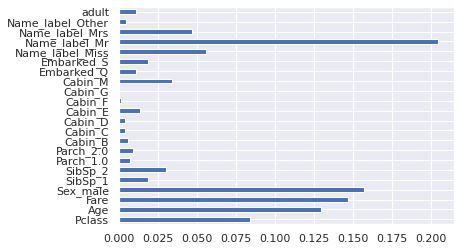

In [370]:
feat_imp = pd.Series(rf_grid_search.best_estimator_.feature_importances_,index = x_train.columns)
feat_imp.plot(kind='barh')

In [371]:
random_forest_accuracy_grid = rf_grid_search.score(x_test,y_test)
print(random_forest_accuracy_grid)

0.8491620111731844


In [372]:
y_pred_grid = rf_grid_search.predict(x_test)
print(confusion_matrix(y_test,y_pred_grid))
print(classification_report(y_test,y_pred_grid))

[[100  10]
 [ 17  52]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



In [379]:
test = pd.read_csv('../input/titanic/test.csv')
titanic_submission = pd.DataFrame(test['PassengerId'])
titanic_submission['Survived'] = rf_grid_search.predict(test_final)
titanic_submission.to_csv('./titanic_dataset_prediction.csv',index=False)